In [1]:
source('source.r')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


Loading required package: ncdf4
Loading required package: R.matlab
R.matlab v3.6.1 (2016-10-19) successfully loaded. See ?R.matlab for help.

Attaching package: ‘R.matlab’

The following objects are masked from ‘package:base’:

    getOption, isOpen

Loading required package: openxlsx
Loading required package: RColorBrewer
Loading required package: compiler
Loading required package: lattice
Loading required package: geosphere
Loading required package: readxl
Loading required package: data.table
Loading required package: rworldmap
Loading required package: sp
Error: package or namespace load failed for ‘rworldmap’ in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 there is no package called ‘fields’
Loading required package: rworldxtra


In [2]:
input.dir = 'Raw Data/FRRF/'

frrf.files = list.files(input.dir, pattern = '*.csv')

length(frrf.files)

[1] 929

In [3]:
get.data = function(input.dir, file.name) {
    file = paste0(input.dir, file.name)
    
    year = substr(file.name, 1, 4)
    month = substr(file.name, 5, 6)
    day = substr(file.name, 7, 8)
    hour = substr(file.name, 10, 11)
    minute = substr(file.name, 12, 13)
    second = substr(file.name, 14, 15)
    
    datetime = as.POSIXct(paste0(year, '-', month, '-', day, ' ', hour, ':', minute, ':', second))
    
    data.a = fread(file, sep = ',', skip = 29, nrows = 21, showProgress = FALSE)
    data.a = data.a[,-c(1, 23, 31)]
    
    #data.b = fread(file, sep = ',', skip = 53, nrows = 21)
    #data.b = data.b[,-c(1, 23, 31)]
    
    #data.c = fread(file, sep = ',', skip = 77, nrows = 21)
    #data.c = data.c[,-c(1, 23, 31)]
    
    #data.d = fread(file, sep = ',', skip = 101, nrows = 21)
    #data.d = data.d[,-c(1, 23, 31)]
    
    data.s = fread(file, sep = ',', skip = 1, nrows = 6)
    
    #list(Time = datetime, A = data.a, B = data.b, C = data.c, D = data.d, S = data.s)
    list(Time = datetime, A = data.a, S = data.s)
}

In [4]:
data = get.data(input.dir, frrf.files[1])

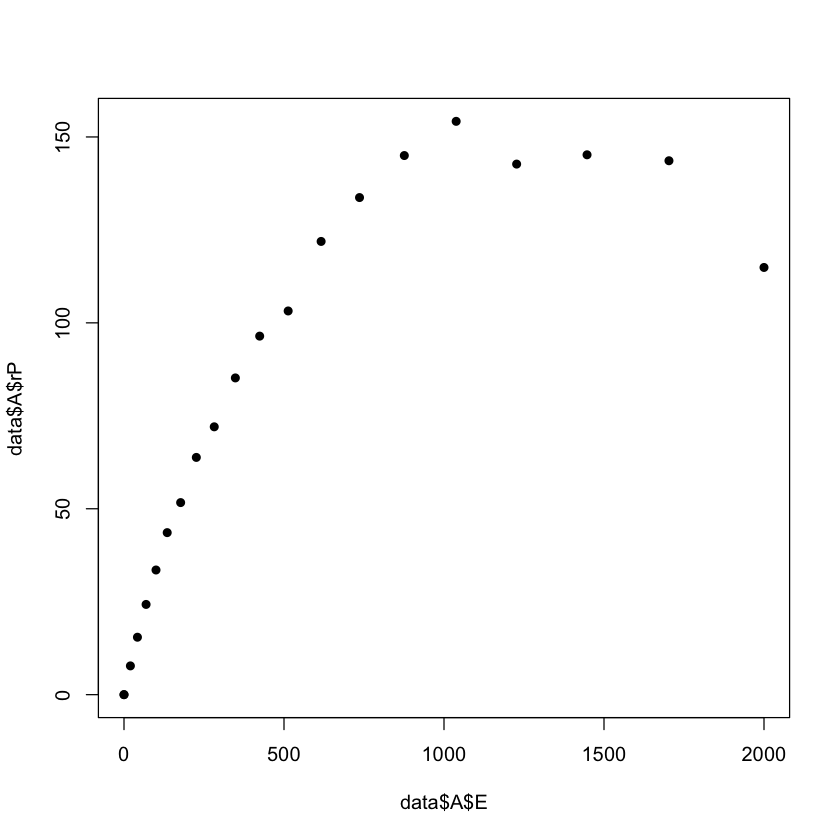

In [5]:
plot(data$A$E, data$A$rP, pch = 16)
points(data$B$E, data$B$rP, pch = 16, col='blue')
points(data$C$E, data$C$rP, pch = 16, col='dark red')
points(data$D$E, data$D$rP, pch = 16, col='dark green')

In [6]:
load('RStates/ship.ncp.rdata')

In [7]:
get.chl = function() {
    temp = get.data(input.dir = input.dir, file = frrf.files[1])
    chl = data.frame(Date = as.numeric(temp$Time), Chl = temp$A[1,5])
    
    for (i in 2:length(frrf.files)) {
        temp = get.data(input.dir = input.dir, file = frrf.files[i])
        chl = rbind(chl, data.frame(Date = as.numeric(temp$Time), Chl = temp$A[1,5]))
    }
    chl
}

In [35]:
options(warn=-1)
chl = get.chl()
chl$Date = as.POSIXct(chl$Date, origin = '1970-01-01 00:00:00', tz = 'PDT')
str(chl)

'data.frame':	929 obs. of  2 variables:
 $ Date  : POSIXct, format: "2017-05-31 17:52:36" "2017-05-31 18:42:02" ...
 $ X.Chl.: num  12.08 21.06 8.21 3.97 4.12 ...


In [36]:
chl$ship = 0
for (i in 1:nrow(chl)) {
    chl$ship[i] = median(ship.data$FL[which(as.numeric(difftime(chl$Date[i], ship.data$DT, units = 'mins'))^2 < 15^2)], na.rm = TRUE)
}


Call:
lm(formula = ship ~ X.Chl. + 0, data = chl)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.2939  -0.6554   0.1380   2.6641  12.7499 

Coefficients:
       Estimate Std. Error t value Pr(>|t|)    
X.Chl. 0.097390   0.003933   24.76   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.262 on 916 degrees of freedom
  (12 observations deleted due to missingness)
Multiple R-squared:  0.4009,	Adjusted R-squared:  0.4003 
F-statistic: 613.1 on 1 and 916 DF,  p-value: < 2.2e-16


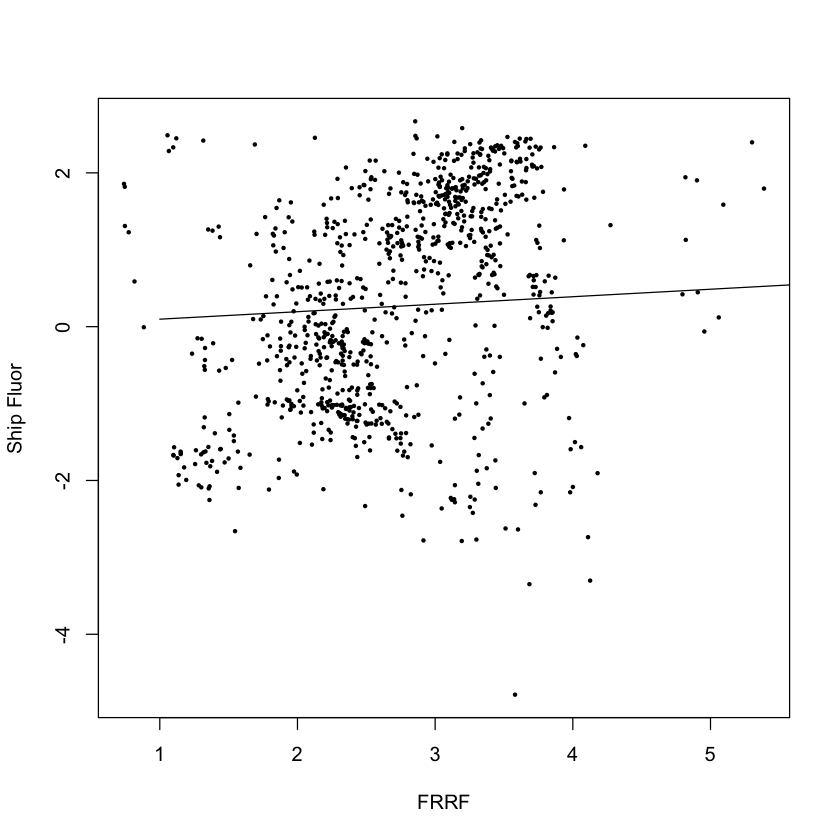

In [38]:
#plot(ship.data$DT, ship.data$FL, pch=20, cex=0.1, ylim=c(0,100), yaxs='i')
#points(chl$Date, chl$X.Chl., pch=15, col='dark green', cex=0.3)
plot(log(chl$X.Chl.), log(chl$ship), pch=16, cex=0.5, ylab='Ship Fluor', xlab='FRRF')

lm.chl = lm(ship ~ X.Chl. + 0, data = chl)
lines(c(1:100), predict(lm.chl, newdata = data.frame(X.Chl. = c(1:100))))

summary(lm.chl)